# Unzip file Caltech101 from the internet

In [ ]:
!unzip /content/caltech-101.zip

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, models, transforms
from torch.utils.data import DataLoader, random_split
import matplotlib.pyplot as plt
import torchvision
import numpy as np
import random

# Continue to extract file tar gz

In [ ]:
!tar -xvzf /content/caltech-101/101_ObjectCategories.tar.gz


# Check device which using GPU ('cuda') or CPU

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cpu')

# Using Data Augumentation to setting the transform image and resize image to 128 for practicing. Input the mean and std of nomalize to make standard color values

In [6]:
transform_image = transforms.Compose(
    [
        transforms.Resize((128, 128)),
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(10),
        transforms.ToTensor(),
        transforms.Normalize(mean = [0.485, 0.456, 0.406], std = [0.229, 0.224, 0.225])
])

dataset = datasets.ImageFolder(root = 'extracted_files/101_ObjectCategories', transform = transform_image)

# Split random data

In [7]:
train_dataset, val_dataset = random_split(dataset, [int(0.8 * len(dataset)), len(dataset) - int(0.8 * len(dataset))])

In [8]:
len(train_dataset), len(val_dataset)

(7315, 1829)

# Create train and test loader for training

In [9]:
train_loader = DataLoader(train_dataset, batch_size = 32, shuffle = True)
val_loader = DataLoader(val_dataset, batch_size = 32, shuffle = False)

# Check images and labels torch size

In [10]:
for images, labels in train_loader:
  print(images.shape, labels.shape)
  break

torch.Size([32, 3, 128, 128]) torch.Size([32])


In [11]:
random_index = random.randint(0, len(dataset) - 1)
random_index

4269

In [12]:
len(dataset.classes)

102

# Create and check classes from *dataset*

In [13]:
classes = dataset.classes
classes

['BACKGROUND_Google',
 'Faces',
 'Faces_easy',
 'Leopards',
 'Motorbikes',
 'accordion',
 'airplanes',
 'anchor',
 'ant',
 'barrel',
 'bass',
 'beaver',
 'binocular',
 'bonsai',
 'brain',
 'brontosaurus',
 'buddha',
 'butterfly',
 'camera',
 'cannon',
 'car_side',
 'ceiling_fan',
 'cellphone',
 'chair',
 'chandelier',
 'cougar_body',
 'cougar_face',
 'crab',
 'crayfish',
 'crocodile',
 'crocodile_head',
 'cup',
 'dalmatian',
 'dollar_bill',
 'dolphin',
 'dragonfly',
 'electric_guitar',
 'elephant',
 'emu',
 'euphonium',
 'ewer',
 'ferry',
 'flamingo',
 'flamingo_head',
 'garfield',
 'gerenuk',
 'gramophone',
 'grand_piano',
 'hawksbill',
 'headphone',
 'hedgehog',
 'helicopter',
 'ibis',
 'inline_skate',
 'joshua_tree',
 'kangaroo',
 'ketch',
 'lamp',
 'laptop',
 'llama',
 'lobster',
 'lotus',
 'mandolin',
 'mayfly',
 'menorah',
 'metronome',
 'minaret',
 'nautilus',
 'octopus',
 'okapi',
 'pagoda',
 'panda',
 'pigeon',
 'pizza',
 'platypus',
 'pyramid',
 'revolver',
 'rhino',
 'rooste

Print out first single image from dataset

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.2391288].


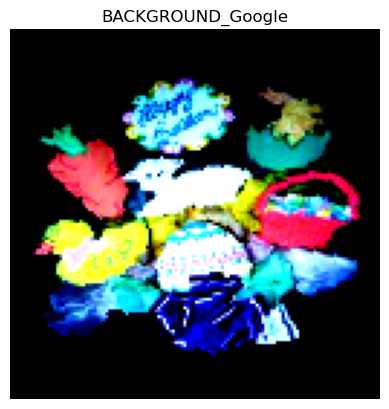

In [19]:
single_image = dataset[50][0]
single_image = single_image.permute(1,2,0)
plt.imshow(single_image)
plt.title(dataset.classes[dataset[50][1]])
plt.axis('off')
plt.show()

# Print out 32 images randomly

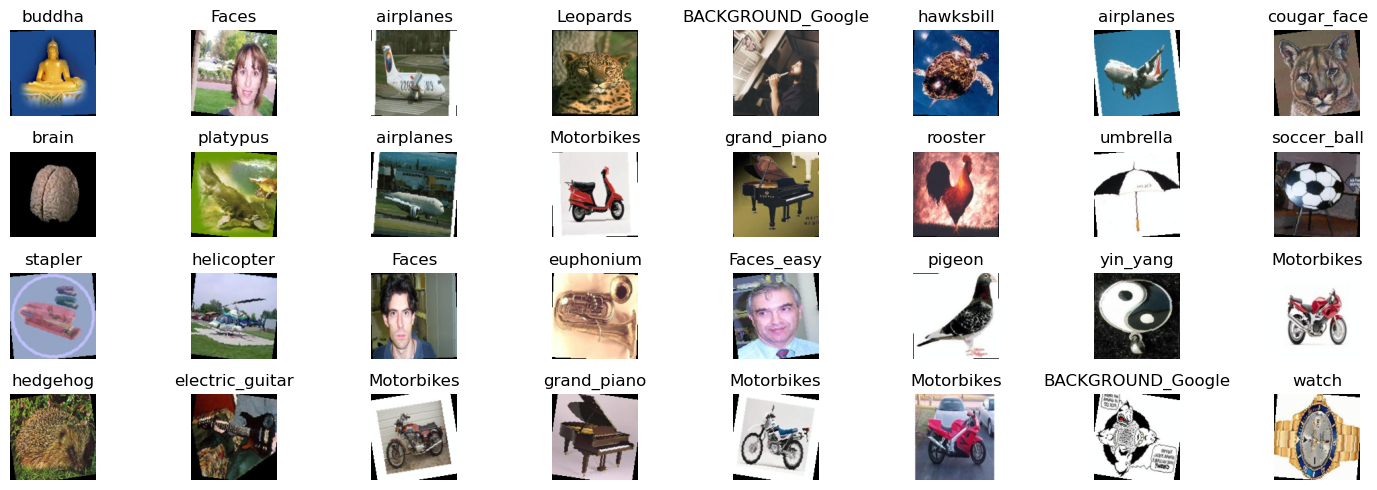

In [20]:
fig, axes = plt.subplots(nrows=4, ncols=8, figsize=(15, 5))
axes = axes.flatten()
for i in range(32):
    random_index = random.randint(0, len(dataset) - 1)
    image, label = dataset[random_index]

    # Reverse normalization
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    image = image.permute(1, 2, 0).numpy()  # Convert to NumPy array
    image = std * image + mean  # Reverse normalization
    image = np.clip(image, 0, 1)  # Clip values to [0, 1]


    axes[i].imshow(image)
    axes[i].set_title(dataset.classes[label])
    axes[i].axis('off')

plt.tight_layout()
plt.show()

# Create 2D Convolution neuron network define which a sequence of layers with 3 chanels (RGB) then return output of the network has been processed by all layers

In [21]:
class CNN(nn.Module):
  def __init__(self, number_output):
    super(CNN, self).__init__()
    self.network = nn.Sequential(
        nn.Conv2d(in_channels = 3, out_channels = 32, kernel_size = 3, padding = 'same'), # 32,128,128
        nn.ReLU(),
        nn.MaxPool2d(kernel_size = 2, stride=2),   # 32, 64,64

        nn.Conv2d(in_channels = 32, out_channels = 64, kernel_size = 3, padding = 'same'),  # 32, 64,64
        nn.ReLU(),
        nn.MaxPool2d(kernel_size = 2, stride=2),  # 64, 32,32

        nn.Flatten(),
        nn.Linear(in_features = 64 * 32 * 32, out_features = 256),
        nn.ReLU(),
        nn.Linear(in_features = 256, out_features = 128),
        nn.ReLU(),
        nn.Linear(in_features = 128, out_features = number_output)
    )
  def forward(self, x):
      return self.network(x)

# Training model with train and test model then get the accuracy from scratch

In [22]:
# Training loop
def train_model(model, optimizer, criterion, train_loader, val_loader, num_epochs=5):
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(train_loader):.4f}")

In [26]:
len(dataset.classes)

102

In [31]:
num_classes = len(dataset.classes)
model = CNN(num_classes).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

train_model(model, optimizer, criterion, train_loader, val_loader, num_epochs=1)    

Epoch [1/1], Loss: 3.5559


In [ ]:
def test_model(model, val_loader):
  with torch.no_grad():
      model.eval()
      total = 0
      correct = 0
      for images, labels in val_loader:
        images, labels = images.to(device), labels.to(device)

        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        correct += (predicted == labels).sum().item()
        total += labels.size(0)
  print(f"accuracy : {100 * correct / total:.4f}")

test_model(model, val_loader)

In [ ]:
num_classes

# Using 1 function to training and evaluation model

In [ ]:
# Training loop
def train_model2(model, optimizer, criterion, train_loader,val_loader, num_epochs=1):
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(train_loader):.4f}")

    with torch.no_grad():
        model.eval()
        total = 0
        correct = 0
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)

            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)
        print(f"accuracy : {100 * correct / total:.4f}")

# Try with Pretrained model call Resnet18 to compare the accuracy

In [ ]:
from torchvision import models

model = models.resnet18(pretrained=True)
model.fc = nn.Linear(model.fc.in_features, num_classes)

model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

train_model2(model, optimizer, criterion, train_loader, val_loader, num_epochs=1)

# Pretrained with EfficientNet

In [ ]:
model = models.efficientnet_b0(weights = 'DEFAULT')
model.classifier[-1] = nn.Linear(model.classifier[-1].in_features, num_classes)
model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
train_model2(model, optimizer, criterion, train_loader, val_loader, num_epochs=1)

# We can see, the 2 pretrained model got better accruracy than nornal training.

# Print out 25 images randomly to check the accuracy of the model

In [ ]:
fig, axes = plt.subplots(nrows=5, ncols=5, figsize=(15, 10))
axes = axes.flatten()
for i in range(25):
    random_index = random.randint(0, len(dataset) - 1)  # Get a random image from the dataset
    image, label = dataset[random_index]                # Get the image and its label

    # Make prediction for the image (Move image to device and get prediction)
    image_tensor = image.unsqueeze(0).to(device)       # Add a batch dimension
    with torch.no_grad():
        model.eval()
        output = model(image_tensor)
    _, predicted = torch.max(output.data, 1)
    predicted_class = predicted.item()                  # Get the predicted class as an integer

    # Display the image with predicted and true labels
    image = image.permute(1, 2, 0).cpu().numpy()
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    image = std * image + mean
    image = np.clip(image, 0, 1)
    axes[i].imshow(image)
    axes[i].set_title(f"pred : {classes[predicted_class]}, true : {classes[label]}")
    axes[i].axis('off')

plt.tight_layout()
plt.show()